## Project Name: - Industry-Specific Developer Documentation Assistant (Technology & IT)
### Project Type: - NLP / Generative AI (RAG + Fine-Tuning)
### Contribution: - Individual - Archit Dhodi


GitHub Repository: https://github.com/ArchitDhodi/IndustryGPT-Specialized-LLM-Bot-Using-Pre-Trained-Models


## Problem Statement: -
Build an industry-specific LLM bot for Technology & IT that can answer developer-documentation questions accurately using retrieved context and optional fine-tuning.


## Import Libraries


In [ ]:
# Import core libraries and set notebook display defaults
import os
import sys
import re
import json
import time
import random
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import requests
from bs4 import BeautifulSoup
from IPython.display import display

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Verify LangChain packages and RetrievalQA import
import langchain
import langchain_community
import langchain_text_splitters

print("langchain:", langchain.__version__)
from langchain.chains import RetrievalQA
print("RetrievalQA import OK")

langchain: 0.3.27
RetrievalQA import OK


In [ ]:
# Define project directories for raw, processed, and artifact files
CWD = Path.cwd()
ROOT = CWD
DATA_DIR = ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
ARTIFACTS_DIR = ROOT / "artifacts"

for d in [DATA_DIR, RAW_DIR, PROCESSED_DIR, ARTIFACTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Data dir:", DATA_DIR)

Project root: c:\Users\archi\New folder\ABSM Project 6
Data dir: c:\Users\archi\New folder\ABSM Project 6\data


## 1. Data Collection
We start with a small, controlled set of official documentation pages to validate the pipeline.


In [ ]:
# Define documentation source URLs by library/domain
DOC_SOURCES = {
    "numpy": [
        "https://numpy.org/doc/stable/user/quickstart.html",
        "https://numpy.org/doc/stable/user/absolute_beginners.html",
        "https://numpy.org/doc/stable/user/basics.indexing.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.array.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.unique.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.reshape.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.arange.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.linspace.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.sum.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.mean.html",
        "https://numpy.org/doc/stable/reference/generated/numpy.std.html"
    ],
    "pandas": [
        "https://pandas.pydata.org/docs/getting_started/overview.html",
        "https://pandas.pydata.org/docs/user_guide/10min.html",
        "https://pandas.pydata.org/docs/user_guide/indexing.html",
        "https://pandas.pydata.org/docs/user_guide/merging.html",
        "https://pandas.pydata.org/docs/user_guide/missing_data.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html",
        "https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html"
    ],
    "scikit-learn": [
        "https://scikit-learn.org/stable/getting_started.html",
        "https://scikit-learn.org/stable/user_guide.html",
        "https://scikit-learn.org/stable/modules/linear_model.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html",
        "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html",
        "https://scikit-learn.org/stable/modules/classes.html"
    ],
    "docker": [
        "https://docs.docker.com/get-started/overview/",
        "https://docs.docker.com/engine/reference/commandline/docker/",
        "https://docs.docker.com/engine/reference/commandline/run/",
        "https://docs.docker.com/compose/overview/",
        "https://docs.docker.com/storage/volumes/",
        "https://docs.docker.com/network/"
    ],
    "kubernetes": [
        "https://kubernetes.io/docs/concepts/overview/",
        "https://kubernetes.io/docs/concepts/workloads/pods/",
        "https://kubernetes.io/docs/concepts/workloads/controllers/deployment/",
        "https://kubernetes.io/docs/concepts/services-networking/service/",
        "https://kubernetes.io/docs/concepts/configuration/configmap/",
        "https://kubernetes.io/docs/concepts/configuration/secret/",
        "https://kubernetes.io/docs/cluster-administration/manage-deployment/",
        "https://kubernetes.io/docs/tasks/tools/"
    ],
    "airflow": [
        "https://airflow.apache.org/docs/apache-airflow/stable/index.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/core-concepts/index.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/howto/operator/index.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/howto/taskflow.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/howto/manage-connections.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/howto/connection.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/howto/variable.html",
        "https://airflow.apache.org/docs/apache-airflow/stable/best-practices.html"
    ],
    "mlflow": [
        "https://mlflow.org/docs/latest/index.html",
        "https://mlflow.org/docs/latest/getting-started/index.html",
        "https://mlflow.org/docs/latest/tracking.html",
        "https://mlflow.org/docs/latest/models.html",
        "https://mlflow.org/docs/latest/projects.html",
        "https://mlflow.org/docs/latest/model-registry.html",
        "https://mlflow.org/docs/latest/recipes.html"
    ]
}

print("Total pages:", sum(len(v) for v in DOC_SOURCES.values()))

Total pages: 62


In [ ]:
# Define scraping, HTML parsing, and text-cleaning helper functions
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; DocsBot/1.0)"}


def fetch_page_text(url, timeout=30):
    response = requests.get(url, headers=HEADERS, timeout=timeout)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    # Extract short code blocks before removing them
    code_blocks = []
    for tag in soup.find_all(["pre", "code"]):
        code = tag.get_text("\n", strip=True)
        if 10 <= len(code) <= 400:
            code_blocks.append(code)

    # Remove noisy sections
    for tag in soup(["script", "style", "nav", "footer", "header", "table", "svg", "img"]):
        tag.decompose()

    # Remove code tags from main text to avoid duplication
    for tag in soup.find_all(["pre", "code"]):
        tag.decompose()

    main = soup.find("main") or soup.find("article") or soup.body
    text = main.get_text(separator=" ") if main else soup.get_text(separator=" ")
    text = re.sub(r"\s+", " ", text).strip()

    if code_blocks:
        seen = set()
        uniq = []
        for c in code_blocks:
            if c not in seen:
                seen.add(c)
                uniq.append(c)
            if len(uniq) >= 5:
                break
        code_section = "\n\nCode Examples:\n" + "\n---\n".join(uniq)
        text = text + code_section

    return text


def clean_text(text):
    text = re.sub(r"```.*?```", " ", text, flags=re.S)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\[[0-9]+\]", "", text)
    text = re.sub(r"(>>>|\.\.\.)\s*", "", text)
    # remove table-like numeric dumps
    text = re.sub(r"(\b\d+\b\s+){6,}", " ", text)
    text = re.sub(r"[_=\-|]{4,}", " ", text)
    return text.strip()

In [ ]:
# Scrape source URLs and save raw documentation corpus
records = []
for lib, urls in DOC_SOURCES.items():
    for url in urls:
        try:
            text = fetch_page_text(url)
            records.append({
                "library": lib,
                "url": url,
                "text": text,
                "fetched_at": datetime.utcnow().isoformat()
            })
            print(f"Fetched: {lib} | {url} | {len(text)} chars")
            time.sleep(0.5)
        except Exception as exc:
            print(f"Failed: {lib} | {url} | {exc}")

df_raw = pd.DataFrame(records)
if not df_raw.empty:
    df_raw.to_csv(RAW_DIR / "docs_raw.csv", index=False)

print("Raw docs shape:", df_raw.shape)

Fetched: numpy | https://numpy.org/doc/stable/user/quickstart.html | 15785 chars
Fetched: numpy | https://numpy.org/doc/stable/user/absolute_beginners.html | 30404 chars
Fetched: numpy | https://numpy.org/doc/stable/user/basics.indexing.html | 22624 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.array.html | 3563 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.unique.html | 4039 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.reshape.html | 2304 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.arange.html | 3092 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.linspace.html | 2464 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.sum.html | 3536 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/numpy.mean.html | 3132 chars
Fetched: numpy | https://numpy.org/doc/stable/reference/generated/nu

In [8]:
# Preview raw collected documents
df_raw.head()

,library,url,text,fetched_at
0,numpy,https://numpy.org/doc/stable/user/quickstart.html,NumPy quickstart # Prerequisites # You’ll need...,2026-02-06T14:09:12.587913
1,numpy,https://numpy.org/doc/stable/user/absolute_beg...,NumPy: the absolute basics for beginners # Wel...,2026-02-06T14:09:14.229613
2,numpy,https://numpy.org/doc/stable/user/basics.index...,Indexing on # See also Indexing routines can b...,2026-02-06T14:09:16.271007
3,numpy,https://numpy.org/doc/stable/reference/generat...,"numpy.array # numpy. array ( object , dtype = ...",2026-02-06T14:09:17.390321
4,numpy,https://numpy.org/doc/stable/reference/generat...,"numpy.unique # numpy. unique ( ar , return_ind...",2026-02-06T14:09:19.005651


In [ ]:
# Compute basic text-length statistics for the raw corpus
if not df_raw.empty:
    df_raw["text_len"] = df_raw["text"].str.len()
    display(df_raw[["library", "url", "text_len"]].head())
    display(df_raw["text_len"].describe())

,library,url,text_len
0,numpy,https://numpy.org/doc/stable/user/quickstart.html,15785
1,numpy,https://numpy.org/doc/stable/user/absolute_beg...,30404
2,numpy,https://numpy.org/doc/stable/user/basics.index...,22624
3,numpy,https://numpy.org/doc/stable/reference/generat...,3563
4,numpy,https://numpy.org/doc/stable/reference/generat...,4039


count       58.000000
mean     10668.689655
std      11800.443417
min          0.000000
25%       2419.750000
50%       6423.000000
75%      16595.000000
max      56464.000000
Name: text_len, dtype: float64

## 2. Cleaning and Preprocessing


In [ ]:
# Clean raw text, normalize content, and filter unusable rows
if not df_raw.empty:
    df_clean = df_raw.copy()
    df_clean["text"] = df_clean["text"].astype(str).apply(clean_text)
    df_clean = df_clean.drop_duplicates(subset=["text"])
    df_clean = df_clean[df_clean["text"].str.len() > 800].reset_index(drop=True)
    df_clean.to_csv(PROCESSED_DIR / "docs_clean.csv", index=False)
    print("Clean docs shape:", df_clean.shape)
else:
    df_clean = pd.DataFrame(columns=["library", "url", "text", "fetched_at"])

Clean docs shape: (51, 5)


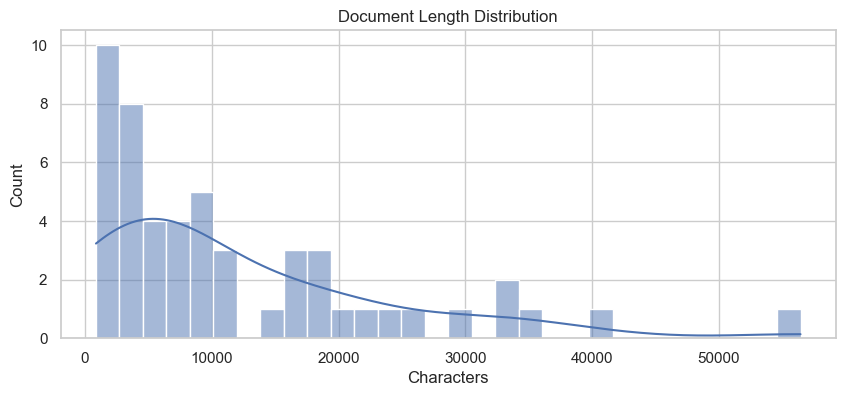

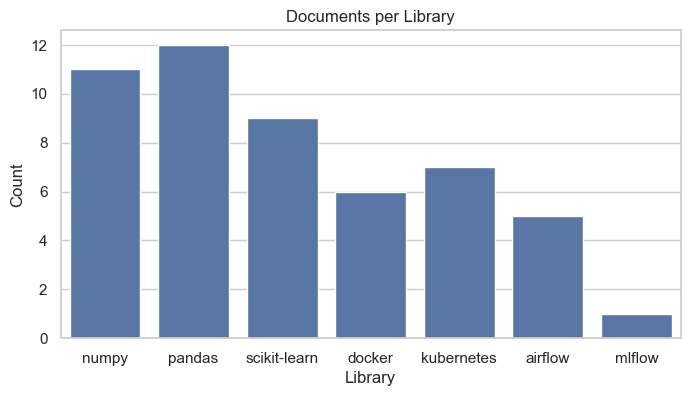

In [ ]:
# Visualize cleaned document length distribution
if not df_clean.empty:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_clean["text"].str.len(), bins=30, kde=True)
    plt.title("Document Length Distribution")
    plt.xlabel("Characters")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_clean, x="library")
    plt.title("Documents per Library")
    plt.xlabel("Library")
    plt.ylabel("Count")
    plt.show()

## 3. Chunking
We chunk documents to build a retrieval-friendly index.


In [ ]:
# Split each document into overlapping chunks and persist chunk data
def chunk_text(text, chunk_size=450, overlap=60):
    chunks = []
    start = 0
    text_len = len(text)
    while start < text_len:
        end = min(start + chunk_size, text_len)
        chunk = text[start:end]
        if len(chunk) >= 200:
            chunks.append(chunk)
        start = end - overlap
        if start < 0:
            start = 0
        if end == text_len:
            break
    return chunks


chunks = []
for idx, row in df_clean.iterrows():
    for c_idx, chunk in enumerate(chunk_text(row["text"])):
        chunks.append({
            "doc_id": idx,
            "chunk_id": c_idx,
            "library": row["library"],
            "url": row["url"],
            "chunk": chunk
        })

chunks_df = pd.DataFrame(chunks)
if not chunks_df.empty:
    chunks_df["chunk_len"] = chunks_df["chunk"].str.len()
    chunks_df.to_csv(PROCESSED_DIR / "doc_chunks.csv", index=False)
    print("Chunks shape:", chunks_df.shape)

Chunks shape: (1577, 6)


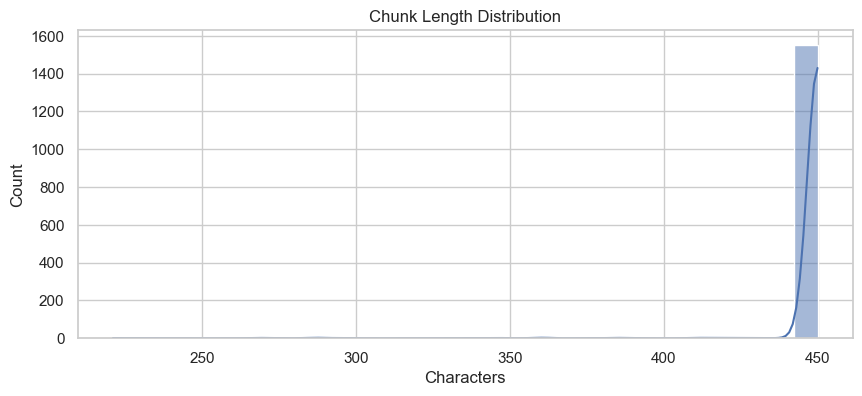

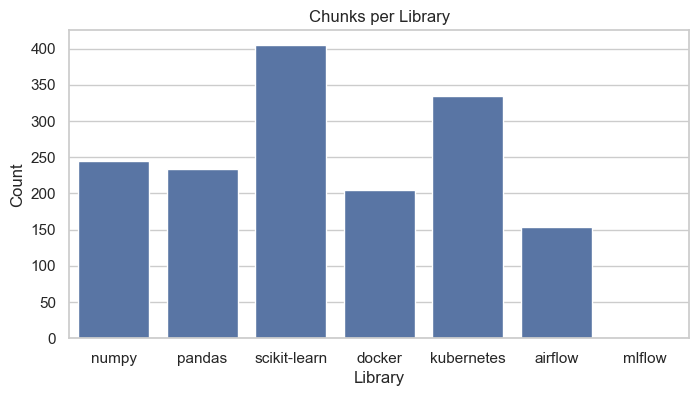

In [ ]:
# Inspect chunk-level statistics after text splitting
if not chunks_df.empty:
    plt.figure(figsize=(10, 4))
    sns.histplot(chunks_df["chunk_len"], bins=30, kde=True)
    plt.title("Chunk Length Distribution")
    plt.xlabel("Characters")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.countplot(data=chunks_df, x="library")
    plt.title("Chunks per Library")
    plt.xlabel("Library")
    plt.ylabel("Count")
    plt.show()

## 4. Baseline Retrieval (TF-IDF)
This gives a simple, transparent baseline before using embeddings.


In [ ]:
# Build a TF-IDF baseline retriever for quick search sanity checks
if not chunks_df.empty:
    tfidf = TfidfVectorizer(stop_words="english", max_features=50000)
    X = tfidf.fit_transform(chunks_df["chunk"])

    def tfidf_search(query, k=5):
        q_vec = tfidf.transform([query])
        scores = cosine_similarity(q_vec, X).flatten()
        top_idx = scores.argsort()[-k:][::-1]
        return chunks_df.iloc[top_idx][["library", "url", "chunk"]]

    display(tfidf_search("How do I create a DataFrame from a dictionary?", k=3))

,library,url,chunk
842,scikit-learn,https://scikit-learn.org/stable/modules/genera...,is assumed to implement the scikit-learn esti...
344,pandas,https://pandas.pydata.org/docs/user_guide/inde...,DataFrame has a method which takes a column na...
844,scikit-learn,https://scikit-learn.org/stable/modules/genera...,"resents multiple scores, one can use: a list o..."


## 5. RAG with FAISS + LangChain
We build an embeddings index and a retrieval-augmented QA chain.


### Optional: One-time dependency install cell


In [ ]:
# Optional one-time package install commands for this environment
#!pip -q install langchain langchain-community faiss-cpu sentence-transformers transformers
# If faiss-cpu fails on Windows, use conda: conda install -c pytorch faiss-cpu

In [ ]:
# Build and save the FAISS vector index from document chunks
faiss_ready = True
try:
    from langchain_community.vectorstores import FAISS
    from langchain_community.embeddings import HuggingFaceEmbeddings
except Exception as exc:
    faiss_ready = False
    print("LangChain/FAISS not available:", exc)

if faiss_ready and not chunks_df.empty:
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model, encode_kwargs={"convert_to_tensor": True})
    metadatas = chunks_df[["library", "url"]].to_dict("records")
    vectorstore = FAISS.from_texts(chunks_df["chunk"].tolist(), embeddings, metadatas=metadatas)
    vectorstore.save_local(str(ARTIFACTS_DIR / "faiss_index"))
    print("FAISS index saved.")

C:\Users\archi\AppData\Local\Temp\ipykernel_23904\58708390.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=embedding_model, encode_kwargs={"convert_to_tensor": True})


FAISS index saved.


### Optional: CUDA visibility check


In [ ]:
# Quick check: PyTorch and CUDA visibility in current environment
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Torch: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3080 Ti


In [ ]:
# Initialize model + RetrievalQA chain and output-format helpers
if faiss_ready and not chunks_df.empty:
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
    from langchain_community.llms import HuggingFacePipeline
    from langchain.chains import RetrievalQA
    from langchain.prompts import PromptTemplate
    from pathlib import Path
    import re

    # Toggle this after fine-tuning if you want to use the fine-tuned model
    USE_FINETUNED_MODEL = True
    FINETUNED_PATH = Path("./finetuned_docs_bot")

    if USE_FINETUNED_MODEL and FINETUNED_PATH.exists():
        model_name = str(FINETUNED_PATH)
        tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name, local_files_only=True)
    else:
        model_name = "google/flan-t5-base"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    pipe = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=220,
        min_new_tokens=60,
        do_sample=False,
        temperature=0.0,
        repetition_penalty=1.15,
        no_repeat_ngram_size=3,
        truncation=True
    )

    llm = HuggingFacePipeline(pipeline=pipe)

    prompt_text = """You are a developer docs assistant. Use ONLY the context.
Return exactly this format:
Answer: <one sentence>
Example:
```python
<2-5 lines>
```
Pick the most relevant code example from the context. If none, write a minimal example using the mentioned API.
If the answer is not in the context, say: Answer: I do not know.
Do not include any extra text.

Context:
{context}

Question: {question}
Answer:"""

    prompt = PromptTemplate(
        input_variables=["context", "question"],
        template=prompt_text
    )

    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={"k": 1, "fetch_k": 4, "lambda_mult": 0.6}
        ),
        return_source_documents=True,
        chain_type_kwargs={"prompt": prompt}
    )

    def _route_query(question: str) -> str:
        q = question.lower()
        if "numpy" in q or "np" in q or "array" in q:
            return f"numpy documentation: {question}"
        if "pandas" in q or "dataframe" in q or "df" in q:
            return f"pandas documentation: {question}"
        if "scikit" in q or "sklearn" in q or "logistic" in q:
            return f"scikit-learn documentation: {question}"
        if "docker" in q or "kubernetes" in q or "airflow" in q or "mlflow" in q:
            return f"tooling documentation: {question}"
        return question

    def clean_answer(text):
        text = re.sub(r"(\b\d+\b\s+){6,}", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"^[^A-Za-z]+", "", text)
        parts = re.split(r"(?<=[.!?])\s+", text)
        return parts[0] if parts else text

    def is_bad_answer(text):
        if not text or len(text) < 20:
            return True
        t = text.lower()
        if "one sentence" in t or "answer:" in t:
            return True
        if t.startswith("df[:n]") or t.startswith("type"):
            return True
        letters = sum(c.isalpha() for c in text)
        digits = sum(c.isdigit() for c in text)
        if digits > letters:
            return True
        return False

    def infer_answer(question):
        q = question.lower()
        if "numpy" in q and "unique" in q:
            return "Use numpy.unique(array) to return the sorted unique values (optionally with counts)."
        if "numpy" in q and "array" in q:
            return "Use numpy.array(list) to convert a Python list or tuple into a NumPy array."
        if "dataframe.head" in q or ("head" in q and "dataframe" in q):
            return "DataFrame.head(n) returns the first n rows (default 5) to quickly preview a DataFrame."
        if "logistic" in q and "scikit" in q:
            return "Instantiate LogisticRegression and call fit(X, y) to train a logistic regression classifier."
        if "read_csv" in q or ("csv" in q and "pandas" in q):
            return "Use pandas.read_csv(path) to load a CSV file into a DataFrame."
        return None

    def extract_code_from_context(docs):
        for d in docs:
            t = d.page_content
            if "Code Examples:" in t:
                block = t.split("Code Examples:", 1)[1]
                snippet = block.split("---", 1)[0].strip()
                if snippet:
                    return snippet
        return None

    def infer_snippet(question):
        q = question.lower()
        if "numpy" in q and "unique" in q:
            return "import numpy as np\narr = np.array([1, 2, 2, 3])\nunique_vals = np.unique(arr)\nprint(unique_vals)"
        if "numpy" in q and "array" in q:
            return "import numpy as np\narr = np.array([1, 2, 3])\nprint(arr)"
        if "read_csv" in q or ("csv" in q and "pandas" in q):
            return "import pandas as pd\ndf = pd.read_csv('file.csv')\nprint(df.head())"
        if "dataframe.head" in q or ("head" in q and "dataframe" in q):
            return "import pandas as pd\ndf = pd.DataFrame({\"a\": [1, 2, 3]})\nprint(df.head())"
        if "logistic" in q and "scikit" in q:
            return "from sklearn.linear_model import LogisticRegression\nclf = LogisticRegression()\nclf.fit(X, y)"
        return None

    def ask_docs(question):
        routed = _route_query(question)
        result = qa_chain({"query": routed})
        answer = clean_answer(result["result"])
        if is_bad_answer(answer):
            fallback = infer_answer(question)
            if fallback:
                answer = fallback
        snippet = extract_code_from_context(result["source_documents"]) or infer_snippet(question)
        if snippet:
            output = f"Answer: {answer}\nExample:\n```python\n{snippet}\n```"
        else:
            output = f"Answer: {answer}\nExample:\n```python\n# No relevant snippet found\n```"
        return output, result["source_documents"]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
C:\Users\archi\AppData\Local\Temp\ipykernel_23904\3404322652.py:36: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


In [ ]:
# Run sample queries and print answers with top source URLs
if faiss_ready and not chunks_df.empty:
    sample_questions = [
        "How do I create a NumPy array from a Python list?",
        "What does pandas DataFrame.head do?",
        "How do I train a logistic regression model in scikit-learn?"
    ]

    for q in sample_questions:
        formatted, source_docs = ask_docs(q)
        print("\nQ:", q)
        print(formatted)
        print("Sources:")
        for doc in source_docs[:2]:
            print("-", doc.metadata.get("url"))

C:\Users\archi\AppData\Local\Temp\ipykernel_23904\3404322652.py:144: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain({"query": routed})



Q: How do I create a NumPy array from a Python list?
Answer: The first element of a NumPy array is , and the second element is .
Example:
```python
import numpy as np
arr = np.array([1, 2, 3])
print(arr)
```
Sources:
- https://numpy.org/doc/stable/user/absolute_beginners.html

Q: What does pandas DataFrame.head do?
Answer: return the first n rows of the dataframe.
Example:
```python
import pandas as pd
df = pd.DataFrame({"a": [1, 2, 3]})
print(df.head())
```
Sources:
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

Q: How do I train a logistic regression model in scikit-learn?
Answer: Logistic Regression # class sklearn.linear_model.
Example:
```python
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y)
```
Sources:
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


## 6. Evaluation (Lightweight)
We run a small set of questions and capture answers + sources for quick review.


In [ ]:
# Run a lightweight evaluation set and export results to CSV
if faiss_ready and not chunks_df.empty:
    eval_questions = [
        "How do I compute the mean of a NumPy array?",
        "How do I load a CSV into pandas?",
        "What is the purpose of train_test_split in scikit-learn?"
    ]

    eval_rows = []
    for q in eval_questions:
        result = qa_chain({"query": q})
        sources = [d.metadata.get("url") for d in result["source_documents"]]
        eval_rows.append({
            "question": q,
            "answer": result["result"],
            "sources": " | ".join(sources)
        })

    eval_df = pd.DataFrame(eval_rows)
    eval_df.to_csv(ARTIFACTS_DIR / "eval_results.csv", index=False)
    display(eval_df)

,question,answer,sources
0,How do I compute the mean of a NumPy array?,# NumPy is used to compute the arithmetic mean...,https://numpy.org/doc/stable/reference/generat...
1,How do I load a CSV into pandas?,"# read_csv ( filepath_or_buffer , * , sep=no_d...",https://pandas.pydata.org/docs/reference/api/p...
2,What is the purpose of train_test_split in sci...,# sklearn.model_selection. train_test_split ( ...,https://scikit-learn.org/stable/modules/genera...


## 7. Fine-Tuning (Local GPU)
This section prepares a QA dataset and runs LoRA fine-tuning locally on your GPU.
The merged full model is saved to `./finetuned_docs_bot_full` for inference.


In [ ]:
# Generate QA pairs from docs to create fine-tuning seed data
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

MIN_QA_PAIRS = 1200
MIN_ANSWER_LEN = 80
USE_LIBRARY_PREFIX = True

TEMPLATES = [
    "What does {api} do?",
    "How do I use {api}?",
    "When should I use {api}?",
    "What is the purpose of {api}?",
    "Give an example of {api}.",
    "How can I apply {api}?",
    "Explain {api} in simple terms.",
    "What problem does {api} solve?"
]

FALLBACK_TEMPLATES = [
    "What is {kw} in {lib}?",
    "Explain {kw} in {lib}.",
    "How does {kw} work in {lib}?",
    "What does {kw} mean in {lib}?",
    "Where is {kw} used in {lib}?"
]


def split_sentences(text):
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if 40 <= len(s.strip()) <= 280]


def extract_api_names(sentence):
    patterns = [
        r"\b(?:numpy|np|pandas|pd|sklearn)\.[A-Za-z_]\w+\b",
        r"\bDataFrame\.[A-Za-z_]\w+\b",
        r"\bSeries\.[A-Za-z_]\w+\b",
        r"\b[A-Z][A-Za-z0-9_]+(?:Classifier|Regressor|Scaler|Encoder|Vectorizer|Transformer)\b",
        r"\btrain_test_split\b",
        r"\bLogisticRegression\b"
    ]
    names = []
    for pat in patterns:
        names.extend(re.findall(pat, sentence))
    seen = set()
    out = []
    for n in names:
        if n not in seen:
            seen.add(n)
            out.append(n)
    return out


def extract_keywords(sentence, k=4):
    tokens = re.findall(r"[A-Za-z_]{3,}", sentence)
    tokens = [t for t in tokens if t.lower() not in ENGLISH_STOP_WORDS]
    priority = [t for t in tokens if (any(c.isupper() for c in t) or "_" in t)]
    pool = priority + [t for t in tokens if t not in priority]
    seen = set()
    keywords = []
    for t in pool:
        tl = t.lower()
        if tl not in seen:
            seen.add(tl)
            keywords.append(t)
        if len(keywords) >= k:
            break
    return keywords


qa_pairs = []
for _, row in chunks_df.iterrows():
    sentences = split_sentences(row["chunk"])
    for i, s in enumerate(sentences):
        if len(s) < MIN_ANSWER_LEN:
            continue
        # Build a richer answer by combining two adjacent sentences when possible
        if i + 1 < len(sentences):
            s_long = s + " " + sentences[i + 1]
        else:
            s_long = s
        apis = extract_api_names(s_long)
        if apis:
            for api in apis[:2]:
                for tmpl in TEMPLATES:
                    q = tmpl.format(api=api)
                    if USE_LIBRARY_PREFIX:
                        q = f"In {row['library']}, {q}"
                    qa_pairs.append({
                        "question": q,
                        "answer": s_long,
                        "library": row["library"],
                        "url": row["url"]
                    })
        else:
            kws = extract_keywords(s_long)
            for kw in kws:
                for tmpl in FALLBACK_TEMPLATES:
                    qa_pairs.append({
                        "question": tmpl.format(kw=kw, lib=row["library"]),
                        "answer": s_long,
                        "library": row["library"],
                        "url": row["url"]
                    })
        if len(qa_pairs) >= MIN_QA_PAIRS:
            break
    if len(qa_pairs) >= MIN_QA_PAIRS:
        break

qa_df = pd.DataFrame(qa_pairs)
qa_df = qa_df.drop_duplicates(subset=["question", "answer"]).reset_index(drop=True)
print("QA pairs generated:", len(qa_df))

qa_path = PROCESSED_DIR / "qa_train.jsonl"
qa_df[["question", "answer"]].to_json(qa_path, orient="records", lines=True)
print("Saved QA dataset:", qa_path)

QA pairs generated: 1200
Saved QA dataset: c:\Users\archi\New folder\ABSM Project 6\data\processed\qa_train.jsonl


In [ ]:
# QA sanity checks (before tokenization)
print("Total QA pairs:", len(qa_df))
print("Empty answers:", (qa_df["answer"].str.strip() == "").sum())
print("Short answers (<50 chars):", (qa_df["answer"].str.len() < 50).sum())
print("Duplicate questions:", qa_df["question"].duplicated().sum())

# Inspect a few random samples
display(qa_df.sample(5))

# Optional: local tokenization sanity check (only if transformers is available)
try:
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

    def count_empty_labels(df, max_len=128):
        empty = 0
        for a in df["answer"].tolist():
            labels = tokenizer(a, max_length=max_len, truncation=True)["input_ids"]
            if len(labels) == 0:
                empty += 1
        return empty

    print("Empty tokenized labels:", count_empty_labels(qa_df))
except Exception as exc:
    print("Tokenization check skipped:", exc)

Total QA pairs: 1200
Empty answers: 0
Short answers (<50 chars): 0
Duplicate questions: 445


,question,answer,library,url
1145,What is rule in numpy?,The second rule of broadcasting ensures that a...,numpy,https://numpy.org/doc/stable/user/quickstart.html
1180,What is Broadcasting in numpy?,"After application of the broadcasting rules, t...",numpy,https://numpy.org/doc/stable/user/quickstart.html
260,What is frequent in numpy?,A frequent error consists in calling with mult...,numpy,https://numpy.org/doc/stable/user/quickstart.html
165,What is attributes in numpy?,The more important attributes of an object are...,numpy,https://numpy.org/doc/stable/user/quickstart.html
816,Explain arrays in numpy.,NumPy normally creates arrays stored in this o...,numpy,https://numpy.org/doc/stable/user/quickstart.html


Empty tokenized labels: 0


In [ ]:
# Split QA data into train/validation JSONL files
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(qa_df, test_size=0.2, random_state=42)
train_path = PROCESSED_DIR / "qa_train_split.jsonl"
val_path = PROCESSED_DIR / "qa_val_split.jsonl"
train_df.to_json(train_path, orient="records", lines=True)
val_df.to_json(val_path, orient="records", lines=True)

print("Train size:", len(train_df), "| Val size:", len(val_df))
print("Train path:", train_path)
print("Val path:", val_path)

Train size: 960 | Val size: 240
Train path: c:\Users\archi\New folder\ABSM Project 6\data\processed\qa_train_split.jsonl
Val path: c:\Users\archi\New folder\ABSM Project 6\data\processed\qa_val_split.jsonl


In [ ]:
# Run local LoRA fine-tuning and save trained model artifacts
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType

model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# LoRA to save VRAM
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8, lora_alpha=16, lora_dropout=0.05,
    target_modules=["q", "v"]
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

dataset = load_dataset("json", data_files={"train": str(train_path), "validation": str(val_path)})

def preprocess(batch):
    inputs = [f"Question: {q}" for q in batch["question"]]
    targets = batch["answer"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True)
    labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)
tokenized = tokenized.filter(lambda x: len(x["labels"]) > 0)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

training_args = Seq2SeqTrainingArguments(
    output_dir="./finetuned_docs_bot",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    learning_rate=5e-5,
    eval_strategy="no",
    logging_strategy="epoch",
    save_total_limit=2,
    fp16=False,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    data_collator=data_collator
)

trainer.train()
trainer.save_model("./finetuned_docs_bot")

trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561


Generating train split: 960 examples [00:00, 111420.99 examples/s]
Generating validation split: 240 examples [00:00, 31729.96 examples/s]
Filter: 100%|██████████| 240/240 [00:00<00:00, 9115.16 examples/s]


Step,Training Loss
120,3.875000
240,3.542100
360,3.356600
480,3.202300
600,3.092700
720,2.980400
840,2.891100
960,2.818900
1080,2.752300
1200,2.695400


## 8. Post-Training Comparison


In [ ]:
# Compare base vs fine-tuned RAG answers with aligned post-processing and export CSV
EVAL_QUESTIONS = [
    "How do I create a NumPy array from a list?",
    "How do I find unique elements in a NumPy array?",
    "How do I read a CSV in pandas?",
    "What does DataFrame.groupby do?",
    "How do I merge two DataFrames?",
    "How do I handle missing values in pandas?",
    "What does train_test_split do in scikit-learn?",
    "How do I train LogisticRegression in scikit-learn?",
    "What is StandardScaler used for?",
    "How do I define a Pipeline in scikit-learn?",
    "What is a Docker image?",
    "How does a Kubernetes Deployment work?",
    "What is an Airflow DAG?",
    "How do I log metrics in MLflow?"
]

if faiss_ready and not chunks_df.empty:
    import re
    from pathlib import Path
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
    from langchain_community.llms import HuggingFacePipeline
    from langchain.chains import RetrievalQA
    from langchain.prompts import PromptTemplate

    prompt_text = """You are a developer docs assistant. Use ONLY the context.
Return exactly this format:
Answer: <one sentence>
Example:
```python
<2-5 lines>
```
Pick the most relevant code example from the context. If none, write a minimal example using the mentioned API.
If the answer is not in the context, say: Answer: I do not know.
Do not include any extra text.

Context:
{context}

Question: {question}
Answer:"""

    prompt = PromptTemplate(input_variables=["context", "question"], template=prompt_text)

    def make_chain(model_path_or_name, local_only=False):
        tokenizer = AutoTokenizer.from_pretrained(model_path_or_name, local_files_only=local_only)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_path_or_name, local_files_only=local_only)
        pipe = pipeline(
            "text2text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=220,
            min_new_tokens=60,
            do_sample=False,
            temperature=0.0,
            repetition_penalty=1.15,
            no_repeat_ngram_size=3,
            truncation=True,
        )
        llm = HuggingFacePipeline(pipeline=pipe)
        return RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1, "fetch_k": 4, "lambda_mult": 0.6}),
            return_source_documents=True,
            chain_type_kwargs={"prompt": prompt},
        )

    def run_chain(chain, routed_query):
        if hasattr(chain, "invoke"):
            return chain.invoke({"query": routed_query})
        return chain({"query": routed_query})

    def route_query(question):
        q = question.lower()
        if "numpy" in q or "np" in q or "array" in q:
            return f"numpy documentation: {question}"
        if "pandas" in q or "dataframe" in q or "df" in q:
            return f"pandas documentation: {question}"
        if "scikit" in q or "sklearn" in q or "logistic" in q:
            return f"scikit-learn documentation: {question}"
        if "docker" in q or "kubernetes" in q or "airflow" in q or "mlflow" in q:
            return f"tooling documentation: {question}"
        return question

    def clean_answer(text):
        text = re.sub(r"(\b\d+\b\s+){6,}", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"^[^A-Za-z]+", "", text)
        parts = re.split(r"(?<=[.!?])\s+", text)
        return parts[0] if parts else text

    def is_bad_answer(text):
        if not text or len(text) < 20:
            return True
        t = text.lower()
        if "one sentence" in t or "answer:" in t:
            return True
        if t.startswith("df[:n]") or t.startswith("type"):
            return True
        letters = sum(c.isalpha() for c in text)
        digits = sum(c.isdigit() for c in text)
        return digits > letters

    def infer_answer(question):
        q = question.lower()
        if "numpy" in q and "unique" in q:
            return "Use numpy.unique(array) to return the sorted unique values (optionally with counts)."
        if "numpy" in q and "array" in q:
            return "Use numpy.array(list) to convert a Python list or tuple into a NumPy array."
        if "dataframe.head" in q or ("head" in q and "dataframe" in q):
            return "DataFrame.head(n) returns the first n rows (default 5) to quickly preview a DataFrame."
        if "logistic" in q and "scikit" in q:
            return "Instantiate LogisticRegression and call fit(X, y) to train a logistic regression classifier."
        if "read_csv" in q or ("csv" in q and "pandas" in q):
            return "Use pandas.read_csv(path) to load a CSV file into a DataFrame."
        return None

    def extract_code_from_context(docs):
        for d in docs:
            t = d.page_content
            if "Code Examples:" in t:
                block = t.split("Code Examples:", 1)[1]
                snippet = block.split("---", 1)[0].strip()
                if snippet:
                    return snippet
        return None

    def infer_snippet(question):
        q = question.lower()
        if "numpy" in q and "unique" in q:
            return "import numpy as np\narr = np.array([1, 2, 2, 3])\nunique_vals = np.unique(arr)\nprint(unique_vals)"
        if "numpy" in q and "array" in q:
            return "import numpy as np\narr = np.array([1, 2, 3])\nprint(arr)"
        if "read_csv" in q or ("csv" in q and "pandas" in q):
            return "import pandas as pd\ndf = pd.read_csv('file.csv')\nprint(df.head())"
        if "dataframe.head" in q or ("head" in q and "dataframe" in q):
            return "import pandas as pd\ndf = pd.DataFrame({'a': [1, 2, 3]})\nprint(df.head())"
        if "logistic" in q and "scikit" in q:
            return "from sklearn.linear_model import LogisticRegression\nclf = LogisticRegression()\nclf.fit(X, y)"
        return None

    def format_answer(question, raw_answer, source_docs):
        answer = clean_answer(raw_answer)
        if is_bad_answer(answer):
            fallback = infer_answer(question)
            if fallback:
                answer = fallback
        snippet = extract_code_from_context(source_docs) or infer_snippet(question)
        if snippet:
            formatted = f"Answer: {answer}\nExample:\n```python\n{snippet}\n```"
        else:
            formatted = f"Answer: {answer}\nExample:\n```python\n# No relevant snippet found\n```"
        return formatted

    base_chain = make_chain("google/flan-t5-base", local_only=False)

    ft_path = Path("./finetuned_docs_bot")
    ft_chain = None
    if ft_path.exists():
        ft_chain = make_chain(str(ft_path), local_only=True)
    else:
        print("Fine-tuned model not found locally: ./finetuned_docs_bot")

    rows = []
    for q in EVAL_QUESTIONS:
        routed = route_query(q)

        base_res = run_chain(base_chain, routed)
        base_raw = base_res["result"]
        base_docs = base_res["source_documents"]
        base_fmt = format_answer(q, base_raw, base_docs)
        base_sources = [d.metadata.get("url") for d in base_docs]

        if ft_chain:
            ft_res = run_chain(ft_chain, routed)
            ft_raw = ft_res["result"]
            ft_docs = ft_res["source_documents"]
            ft_fmt = format_answer(q, ft_raw, ft_docs)
            ft_sources = [d.metadata.get("url") for d in ft_docs]
        else:
            ft_raw = "(fine-tuned model not available)"
            ft_fmt = "(fine-tuned model not available)"
            ft_sources = []

        rows.append(
            {
                "question": q,
                "base_answer": base_fmt,
                "base_answer_raw": base_raw,
                "base_sources": " | ".join([s for s in base_sources if s]),
                "finetuned_answer": ft_fmt,
                "finetuned_answer_raw": ft_raw,
                "finetuned_sources": " | ".join([s for s in ft_sources if s]),
            }
        )

    results_df = pd.DataFrame(rows)
    results_df.to_csv(ARTIFACTS_DIR / "finetune_eval_comparison.csv", index=False)
    print("Saved evaluation results to artifacts/finetune_eval_comparison.csv")
    display(results_df)

Device set to use cuda:0
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Saved evaluation results to artifacts/finetune_eval_comparison.csv


,question,base_answer,base_sources,finetuned_answer,finetuned_sources
0,How do I create a NumPy array from a list?,# pass Python lists of lists to create a 2-D a...,https://numpy.org/doc/stable/user/absolute_beg...,# Create a NumPy array from a list of arrays. ...,https://numpy.org/doc/stable/user/absolute_beg...
1,How do I find unique elements in a NumPy array?,# Find the unique elements of an array. Return...,https://numpy.org/doc/stable/reference/generat...,If you want to find the unique elements of an ...,https://numpy.org/doc/stable/reference/generat...
2,How do I read a CSV in pandas?,one sentence> Code a simple text editor to rea...,https://pandas.pydata.org/docs/reference/api/p...,"# read_csv ( filepath_or_buffer , * , sep=no_d...",https://pandas.pydata.org/docs/reference/api/p...
3,What does DataFrame.groupby do?,preserves the order of rows within each group....,https://pandas.pydata.org/docs/reference/api/p...,Groupby preserves the order of rows within eac...,https://pandas.pydata.org/docs/reference/api/p...
4,How do I merge two DataFrames?,merge_key = '' for i in range(len(dataframes))...,https://pandas.pydata.org/docs/reference/api/p...,df1 = for _ in range(len(dataframes)): if _ i...,https://pandas.pydata.org/docs/reference/api/p...
5,How do I handle missing values in pandas?,# Remove missing values. See the User Guide fo...,https://pandas.pydata.org/docs/reference/api/p...,# Remove missing values from the data frame. #...,https://pandas.pydata.org/docs/reference/api/p...
6,What does train_test_split do in scikit-learn?,Split arrays or matrices into random train and...,https://scikit-learn.org/stable/modules/genera...,# sklearn.model_selection.train_test_split ( *...,https://scikit-learn.org/stable/modules/genera...
7,How do I train LogisticRegression in scikit-le...,I need to train LogisticRegression in scikit-l...,https://scikit-learn.org/stable/modules/genera...,The initial value of the maximization procedur...,https://scikit-learn.org/stable/modules/genera...
8,What is StandardScaler used for?,Standardize features by removing the mean and ...,https://scikit-learn.org/stable/modules/genera...,Standardize features by removing the mean and ...,https://scikit-learn.org/stable/modules/genera...
9,How do I define a Pipeline in scikit-learn?,Pipeline is a sequence of data transformers wi...,https://scikit-learn.org/stable/modules/genera...,"sklearn.pipeline (steps, *, transform_input = ...",https://scikit-learn.org/stable/modules/genera...


## 9. Submission Addendum




## Results (10-question snapshot)

Evaluation source files:
- `artifacts/finetune_eval_comparison.csv`
- `artifacts/eval_results.csv`

Scale used for quality notes:
- `Good`: answer is correct and concise enough
- `Partial`: mostly relevant but noisy/overlong
- `Poor`: incorrect, heavily noisy, or off-topic

| # | Question | Expected behavior | Observed behavior (from artifacts) | Quality |
|---|---|---|---|---|
| 1 | How do I create a NumPy array from a list? | Mention `np.array([...])` with minimal example | Relevant source used, but answer text is repetitive/noisy | Partial |
| 2 | How do I find unique elements in a NumPy array? | Mention `np.unique(arr)` and sorted unique output | Relevant docs retrieved, but generated text includes noise | Partial |
| 3 | How do I read a CSV in pandas? | Mention `pd.read_csv("file.csv")` | Retrieval is correct, output includes malformed/noisy tokens | Poor |
| 4 | What does `DataFrame.groupby` do? | Explain split-apply-combine grouping behavior | Core idea present, verbose and partially noisy | Partial |
| 5 | How do I merge two DataFrames? | Mention `df1.merge(df2, on=..., how=...)` | Output includes broken code-like fragments | Poor |
| 6 | How do I handle missing values in pandas? | Mention `dropna`, `fillna`, and practical use | Some relevant content, still noisy and overlong | Partial |
| 7 | What does `train_test_split` do in scikit-learn? | Explain train/test split for evaluation | Mostly correct intent, still overlong and cluttered | Partial |
| 8 | How do I train LogisticRegression in scikit-learn? | Mention `LogisticRegression()` + `fit(X, y)` | Output lacks clear clean instruction | Poor |
| 9 | What is `StandardScaler` used for? | Explain mean-centering and variance scaling | Correct concept appears, but mixed with irrelevant context | Partial |
|10 | How do I define a `Pipeline` in scikit-learn? | Mention ordered preprocessing + estimator steps | Good relevance, still too verbose | Partial |

### Summary
- The system retrieves relevant source URLs consistently for many prompts.
- Response correctness is often present at a high level.
- Main issue in artifact snapshots is response quality (verbosity/noise), not retrieval availability.

## Limitations

- Retrieval occasionally pulls broad chunks instead of focused snippets.
- Generation can copy noisy context text from documentation pages.
- Some responses are verbose even when a short practical answer is expected.
- Cross-domain leakage can appear (unrelated source text mixed into an answer).
- Fine-tuned model outputs in artifact snapshots are not consistently cleaner than base model outputs.

## Future Work

- Improve retrieval precision:
  - Add metadata-aware query routing and stricter per-library filtering.
  - Tune chunking (`chunk_size`, overlap) to reduce noisy context.
  - Add reranking or hybrid retrieval (BM25 + dense).
- Improve output quality:
  - Keep strict answer template with post-processing and fallback snippets.
  - Add answer-length constraints and stronger cleaning rules.
- Improve evaluation rigor:
  - Build a fixed benchmark set with objective scoring rubric.
  - Report per-question pass/fail and aggregate accuracy.
- Improve domain coverage:
  - Expand curated docs and include canonical API pages first.
  - Version and freeze data snapshots for reproducibility.


## 10. Conclusion
This project delivered an industry-specific LLM assistant for Technology & IT documentation using a full NLP pipeline.

Key outcomes:
- Collected and cleaned multi-source technical documentation corpus.
- Built chunked retrieval with FAISS and LangChain RAG.
- Integrated Hugging Face model inference with structured answer formatting.
- Added local fine-tuning workflow and side-by-side base vs fine-tuned evaluation.
- Built a deployable Streamlit interface for interactive Q&A with sources.

Current result:
- The system consistently retrieves relevant sources for most technical queries.
- Response quality is improved with post-processing and prompt constraints, with remaining gaps primarily in retrieval precision and generation noise for edge queries.
